In [1]:
import scipy as sp
import numpy as np
import pyfar as pf
import os

# Define functions

In [2]:
# Generate order (n) and degree (m) indices arrays for sph order N
def get_nm_arrays(N):
    n = np.array([])
    m = np.array([])
    for nn in range(N+1):
        n = np.append(n, nn * np.ones(2*nn+1))
        m = np.append(m, np.arange(-nn, nn+1))
    return n, m

def get_k_from_f(f):
    return ( ( 2*np.pi * f ) / 343 )

def get_max_sph_order(Q, a=1):
    """ Computes maximum spherical harmonics order from number of sampling points 
    and lambda (a) depending on the grid topology. 
    The default for lamda is 1."""
    
    return int ( np.sqrt( (( Q - a ) / a ) + 1) - 1 )

def get_hrtf_eq_dataset( Y_sampling, m, n, frequencies, ear_distance=0.165):
    """ returns eqDataset containing sh coefficients describing 
    the sound incidence at the letf/right ear position on the sphere. 
    length of sh coefficients is length of input frequencies.
    Y_sampling uses same sampling points as sampling, but with higher sph order.""" 

    eq_matrix = []

    p = 1 # arbitrary sound pressure level ???
    radius = ear_distance / 2     
  
    i_n = 1j**n

    Y_left_ear = sp.special.sph_harm(m, n, -np.pi, 0)
    Y_right_ear = sp.special.sph_harm(m, n, np.pi, 0)

    kr = [ get_k_from_f(f) * radius for f in frequencies ]

    for Y_ear in [Y_left_ear, Y_right_ear]:
        # rigid sphere transfer function as described in Pörschmann et al. 2019
        eq_matrix.append( [p * 4*np.pi * i_n * sp.special.spherical_jn(n, z) * Y_ear * np.conjugate(Y_sampling) for z in kr])
    
    eq_dataset = np.sum( np.array( eq_matrix ), axis=3) # sum over all sph kernels (part of inverse psh transformation)
    eq_dataset = np.swapaxes( np.swapaxes(eq_dataset, 1, 2), 0, 1)
    
    return eq_dataset
    
        

# Load hrirs

In [3]:
file = os.path.join(
    r'..',  'assets', 'pp2_HRIRs_measured.sofa')
hrirs, sg, _ = pf.io.read_sofa(file)

# Get spherical harmonics functions for original sampling grid

In [4]:
sph_order = 35 
n, m = get_nm_arrays(sph_order)
Y_sampling = sp.special.sph_harm(m[None, ...], n[None, ...], sg.azimuth[..., None], sg.colatitude[..., None])

Y_sampling.shape # sampling pos, sph kernels
#radius = 1.47
#frequencies = hrirs.frequencies
#Q = np.ma.size(hrirs, axis=0)

(440, 1296)

# Get rigid sphere transfer function (equalization dataset)

In [5]:
frequencies = hrirs.frequencies

eq_dataset = get_hrtf_eq_dataset(Y_sampling, m, n, frequencies)
eq_dataset.shape # left/right ear, frequencies, sampling positions, sph kernels

(440, 2, 129)

# Apply equalization

In [6]:
hrirs.freq.shape # sampling positions, left/right ear, frequencies
number_channels = hrirs.freq.shape[1]

hrtf_equalized = np.zeros((hrirs.freq.shape))

# for every sampling position: divide hrtf with rigid sphere transfer function
for pos_sparse, pos_rsphere in zip(hrirs.freq, eq_dataset):
    for i in range( number_channels ):
        hrtf_equalized[i] = np.divide(pos_sparse[i], pos_rsphere[i])

hrtf_equalized.shape
hrtf_equalized = np.swapaxes(hrtf_equalized, 0, 1)

/var/folders/rf/2tvjwq1n48l_gv0rrdfq6j5r0000gp/T/ipykernel_2435/1762649605.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  hrtf_equalized[i] = np.divide(pos_sparse[i], pos_rsphere[i])


# Get sh cofficients of equalized hrtf (sh-transform)

In [7]:
# get inverse of sh transform kernels
Y_inv = np.linalg.pinv(Y_sampling)

# SH transform
f_nm_L = pf.matrix_multiplication((Y_inv, hrtf_equalized[0]))
f_nm_R = pf.matrix_multiplication((Y_inv, hrtf_equalized[1]))

#  Upsample/interpolate equalized hrtf with dense sph grid (inverse sph transform)

In [8]:
# Equidistant spherical sampling grid
grid = pf.samplings.sph_extremal(n_points=None, sh_order=sph_order, radius=1.47)
print(sph_order)

# Compute Y2 with denser grid
Y2 = sp.special.sph_harm(
    m[None, ...], n[None, ...],
    grid.azimuth[..., None], grid.colatitude[..., None])

# inverse sh transform
print(Y2.shape) # positions, sph kernels
print(f_nm_L.shape)
hrirs_eq_sh_L = pf.matrix_multiplication((Y2, f_nm_L))
hrirs_eq_sh_R = pf.matrix_multiplication((Y2, f_nm_R))

/opt/anaconda3/envs/audio_feature_extraction/lib/python3.11/site-packages/pyfar/samplings/samplings.py:393: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.hyperinterpolation.'
  warnings.warn((
/opt/anaconda3/envs/audio_feature_extraction/lib/python3.11/site-packages/pyfar/classes/coordinates.py:166: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


35
(1296, 1296)
(1296, 129)


# Reconstruct hrtf by dequalization

In [9]:
# multiply upsampled hrtf with rigid sphere transfer function for dequalization
print(hrirs_eq_sh_L.shape)
print(np.swapaxes( np.swapaxes( eq_dataset, 0, 1) [0], 0, 1 ).shape)
hrirs_sh_L = pf.matrix_multiplication((hrirs_eq_sh_L, np.swapaxes( np.swapaxes( eq_dataset, 0, 1) [0], 0, 1 )))
hrirs_sh_R = pf.matrix_multiplication((hrirs_eq_sh_R, np.swapaxes( np.swapaxes( eq_dataset, 0, 1) [1], 0, 1 )))

(1296, 129)
(129, 440)


# Plot specific hrir

/opt/anaconda3/envs/audio_feature_extraction/lib/python3.11/site-packages/pyfar/classes/audio.py:617: UserWarning: Number of samples not given, assuming 2590 samples from 1296 frequency bins.
  warnings.warn(


<Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>

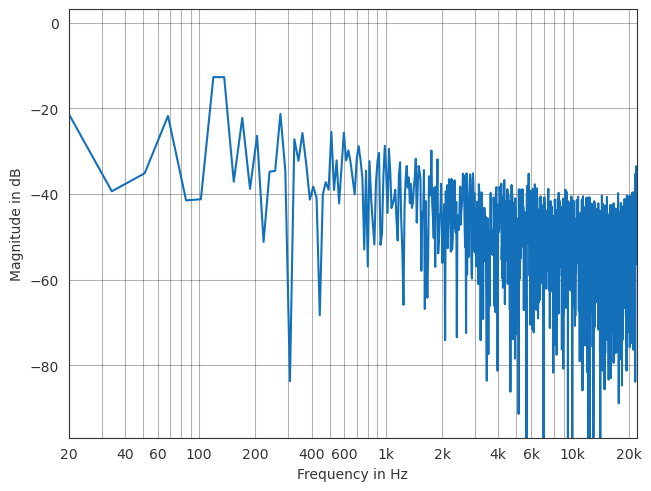

In [10]:
pf.plot.freq(pf.Signal(np.swapaxes(hrirs_sh_L, 0, 1)[0], sampling_rate=44100, domain='freq'))